## De-jitter, estimate the Poisson-Gaussian noise, Trim

In [1]:
%matplotlib inline

import os
import sys
notebook_path = os.path.abspath('.')
sources_path = os.path.abspath(os.path.join(notebook_path, '..'))
sys.path.insert(0, sources_path)

import matplotlib.pylab as plt
import numpy as np
import torch
import logging

from cellmincer.opto_ws import OptopatchBaseWorkspace
from cellmincer.opto_features import OptopatchGlobalFeatureExtractor

from scipy.signal import stft, istft
from sklearn.linear_model import LinearRegression

from abc import abstractmethod
from typing import Tuple

device = torch.device("cuda")
dtype = torch.float64

def new_fig(figsize=(15, 5)):
    fig = plt.figure(figsize=figsize)
    ax = plt.gca()
    return fig, ax

logger = logging.getLogger()
log_info = logger.warning

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

In [2]:
# list of Optopatch movies
opto_mov_path_list = [
    '/home/jupyter/mb-ml-dev-disk/data/Optopatch/original_sami_data/D1_FOV3_W2_at135105.bin',
    '/home/jupyter/mb-ml-dev-disk/data/Optopatch/original_sami_data/D4_FOV2_W2_at171603.bin',
    '/home/jupyter/mb-ml-dev-disk/data/Optopatch/original_sami_data/D4_FOV3_W2_at172029.bin',
    '/home/jupyter/mb-ml-dev-disk/data/Optopatch/original_sami_data/E3_FOV1_W2_at155440.bin',
    '/home/jupyter/mb-ml-dev-disk/data/Optopatch/original_sami_data/F1_FOV2_W1_at143005.bin'
]

# names
opto_mov_prefixes = [
    'D1_FOV3_W2_at135105',
    'D4_FOV2_W2_at171603',
    'D4_FOV3_W2_at172029',
    'E3_FOV1_W2_at155440',
    'F1_FOV2_W1_at143005'
]

n_frames = 7499
width = 512
height = 180

# output
output_path = '/home/jupyter/mb-ml-dev-disk/data/Optopatch/preproc_data'

if not os.path.exists(output_path):
    os.mkdir(output_path)

In [3]:
dejitter_config = {
    'ignore_first_n_frames': 100,
    'detrending_method': 'stft',
    'detrending_order': 3,
    'stft_nperseg': 256,
    'stft_noverlap': 64,
    'stft_lp_cutoff': 80.,
    'stft_lp_slope': 0.25,
    'sampling_rate': 500.,
    'show_diagnostic_plots': True
}

trim_config = {
    'first_segment': 1,
    'n_segments': 10,
    'n_frames_total': 750,
    'n_frames_stim': 250,
    'trim_left': 100,
    'trim_right': 50,
    'n_frames_fit_left': 150,
    'n_frames_fit_right': 150,
    'sampling_rate': 500.
}

noise_estimation_config = {
    'n_bootstrap': 500,
    'stationarity_window': 10,
    'plot_example': True,
    'plot_subsample': 1000
}

bfgs_kwargs = {
    'lr': 1e-1,
    'history_size': 100,
    'max_iter': 100,
    'tolerance_grad': 1e-7,
    'tolerance_change': 1e-9,
    'line_search_fn': 'strong_wolfe'
}

detrend_config = {
    'init_unc_decay_rate': 1.0,
    'poly_order': 3,
    'trend_model': 'polynomial',
    'max_iters_per_segment': 3,
    'plot_segments': True
}

## Helper Methods

In [4]:
def get_trend(
        series_t: np.ndarray,
        detrending_order: int,
        detrending_func: str) -> np.ndarray:
    assert detrending_order > 0
    assert detrending_func in {'mean', 'median'}
    detrending_func_map = {'mean': np.mean, 'median': np.median}
    detrending_func = detrending_func_map[detrending_func]
    
    # reflection pad in time
    padded_series_t = np.pad(
        array=series_t,
        pad_width=((detrending_order, detrending_order)),
        mode='reflect')
    
    trend_series_t = np.zeros_like(series_t)

    # calculate temporal moving average
    for i_t in range(series_t.size):
        trend_series_t[i_t] = detrending_func(padded_series_t[i_t:(i_t + 2 * detrending_order + 1)])

    return trend_series_t


def get_trimmed_segment(
        movie_txy: np.ndarray,
        i_stim: int,
        trim_config: dict,
        tranform_time: bool = True) -> np.ndarray:
    i_t_begin = trim_config['n_frames_total'] * i_stim + trim_config['trim_left']
    i_t_end = trim_config['n_frames_total'] * (i_stim + 1) - trim_config['trim_right']
    i_t_list = [i_t for i_t in range(i_t_begin, i_t_end)]
    if tranform_time:
        t = np.asarray([i_t - i_t_begin for i_t in i_t_list]) / trim_config['sampling_rate']
    else:
        t = i_t_list
    return t, movie_txy[i_t_begin:i_t_end, ...]

def get_flanking_segments(
        movie_txy: np.ndarray,
        i_stim: int,
        trim_config: dict) -> Tuple[np.ndarray, np.ndarray]:
    t_begin_left = (
        trim_config['n_frames_total'] * i_stim
        + trim_config['trim_left'])
    t_end_left = t_begin_left + trim_config['n_frames_fit_left']
    
    t_begin_right = (
        trim_config['n_frames_total'] * (i_stim + 1)
        - trim_config['trim_right']
        - trim_config['n_frames_fit_right'])
    t_end_right = t_begin_right + trim_config['n_frames_fit_right']
    
    i_t_list = (
        [i_t for i_t in range(t_begin_left, t_end_left)]
        + [i_t for i_t in range(t_begin_right, t_end_right)])
    
    t = np.asarray([i_t - t_begin_left for i_t in i_t_list]) / trim_config['sampling_rate']
    
    return t, movie_txy[i_t_list, ...]


class IntensityTrendModel:
    @abstractmethod
    def parameters(self):
        raise NotImplementedError
    
    def get_baseline_txy(self, t: torch.Tensor) -> torch.Tensor:
        raise NotImplementedError


class ExponentialDecayIntensityTrendModel(IntensityTrendModel):
    def __init__(self,
                 t_fit: np.ndarray,
                 fit_seg_txy: np.ndarray,
                 init_unc_decay_rate: float,
                 device: torch.device,
                 dtype: torch.dtype):
        
        # initialize
        self.pos_trans = torch.nn.Softplus()
        self.unc_decay_rate_xy = torch.nn.Parameter(
            init_unc_decay_rate * torch.ones(
                fit_seg_txy.shape[1:], dtype=dtype, device=device))
        
        init_decay_rate = self.pos_trans(torch.tensor(init_unc_decay_rate)).item()
        before_stim_mean_xy = np.mean(fit_seg_txy[:len(t_fit)//2, ...], 0)
        after_stim_mean_xy = np.mean(fit_seg_txy[len(t_fit)//2:, ...], 0)
        t_0 = np.mean(t_fit[:len(t_fit)//2])
        t_1 = np.mean(t_fit[len(t_fit)//2:])
        
        a_xy = torch.tensor(
            (before_stim_mean_xy - after_stim_mean_xy) / (
                np.exp(-init_decay_rate * t_0) - np.exp(-init_decay_rate * t_1)),
            dtype=dtype, device=device)
        b_xy = (torch.tensor(before_stim_mean_xy, dtype=dtype, device=device)
                - np.exp(-init_decay_rate * t_0) * a_xy)
        
        self.a_xy = torch.nn.Parameter(a_xy)
        self.b_xy = torch.nn.Parameter(b_xy)
        
        
    def parameters(self):
        return [self.unc_decay_rate_xy, self.a_xy, self.b_xy]
    
    def get_baseline_txy(self, t: torch.Tensor) -> torch.Tensor:
        decay_rate_xy = self.pos_trans(self.unc_decay_rate_xy)
        return (self.a_xy[None, :, :] * torch.exp(- decay_rate_xy[None, :, :] * t[:, None, None]) +
                self.b_xy[None, :, :])

    
class PolynomialIntensityTrendModel(IntensityTrendModel):
    def __init__(self,
                 t_fit_torch: torch.Tensor,
                 fit_seg_txy_torch: torch.Tensor,
                 poly_order: int,
                 device: torch.device,
                 dtype: torch.dtype):
        assert poly_order >= 1
        self.n_series = torch.arange(0, poly_order + 1, device=device, dtype=torch.int64)

        # initialize to standard linear regression
        tn = t_fit_torch[:, None].pow(self.n_series)
        t_prec_nn = torch.mm(tn.t(), tn).inverse()
        an_xy = torch.einsum('mn,nt,txy->mxy', t_prec_nn, tn.t(), fit_seg_txy_torch).type(dtype)
        
        self.an_xy = torch.nn.Parameter(an_xy)
        
    def parameters(self):
        return [self.an_xy]
    
    def get_baseline_txy(self, t: torch.Tensor) -> torch.Tensor:
        tn = t[:, None].pow(self.n_series)
        return torch.einsum('tn,nxy->txy', tn, self.an_xy)
    
    def get_dd_baseline_txy(self, t: torch.Tensor) -> torch.Tensor:
        n = self.n_series.float()
        pref_n = n * (n - 1)
        dd_tn = pref_n[2:] * t[:, None].pow(self.n_series[:-2])
        return torch.einsum('tn,nxy->txy', dd_tn, self.an_xy[2:])

## De-jitter

In [31]:
i_dataset = 4
ws_base = OptopatchBaseWorkspace.from_bin_uint16(
    opto_mov_path_list[i_dataset], n_frames, width, height)

Loading movie from /home/jupyter/mb-ml-dev-disk/data/Optopatch/original_sami_data/F1_FOV2_W1_at143005.bin ...


In [32]:
# estimate baseline (CCD dc offset)
# this is a heuristic -- ideally, one needs to be given this information!
baseline = np.min(ws_base.movie_txy[dejitter_config['ignore_first_n_frames']:, :, :])
print(f"Baseline CCD dc offset was estimated to be: {baseline:.3f}")

log_movie_txy = np.log(np.maximum(ws_base.movie_txy - baseline, 1.))
log_movie_mean_t = log_movie_txy.mean((-1, -2))

if dejitter_config['detrending_method'] in {'median', 'mean'}:
    
    log_movie_mean_trend_t = get_trend(
        log_movie_mean_t,
        dejitter_config['detrending_order'],
        dejitter_config['detrending_method'])

elif dejitter_config['detrending_method'] == 'stft':
    
    stft_f, stft_t, stft_Zxx = stft(
        log_movie_mean_t,
        boundary='constant',
        fs=dejitter_config['sampling_rate'],
        nperseg=dejitter_config['stft_nperseg'],
        noverlap=dejitter_config['stft_noverlap'])

    jitter_freq_filter = 1. / (1 + np.exp(
        dejitter_config['stft_lp_slope'] * (stft_f - dejitter_config['stft_lp_cutoff'])))

    filtered_Zxx = stft_Zxx * jitter_freq_filter[:, None]
    _, filtered_log_movie_mean_t = istft(
        filtered_Zxx,
        fs=dejitter_config['sampling_rate'],
        nperseg=dejitter_config['stft_nperseg'],
        noverlap=dejitter_config['stft_noverlap'])

    log_movie_mean_trend_t = filtered_log_movie_mean_t[:log_movie_mean_t.size]
    
else:
    
    raise ValueError()

log_jitter_factor_t = log_movie_mean_t - log_movie_mean_trend_t
dejittered_movie_txy = np.exp(log_movie_txy - log_jitter_factor_t[:, None, None]) + baseline

Baseline CCD dc offset was estimated to be: 504.000


Calculating temporal correlation with neighbors ...
Calculating zero-mean movie ...
Calculating temporal mean ...
Calculating temporal std ...


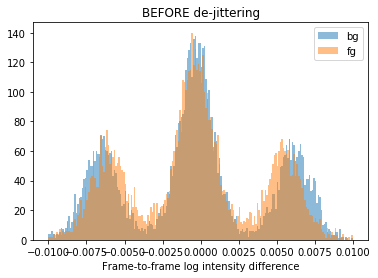

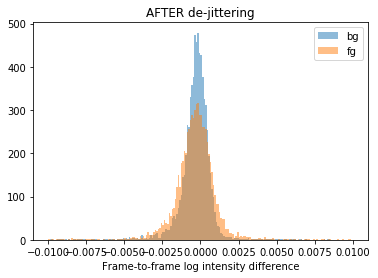

In [33]:
if dejitter_config['show_diagnostic_plots']:
    fg_mask_xy = ws_base.corr_otsu_fg_pixel_mask_xy
    bg_mask_xy = ~fg_mask_xy
    
    # raw frame-to-frame log variations
    fg_raw_mean_t = np.mean(np.log(ws_base.movie_txy.reshape(ws_base.n_frames, -1)[
        dejitter_config['ignore_first_n_frames']:, fg_mask_xy.flatten()] - baseline), axis=-1)
    bg_raw_mean_t = np.mean(np.log(ws_base.movie_txy.reshape(ws_base.n_frames, -1)[
        dejitter_config['ignore_first_n_frames']:, bg_mask_xy.flatten()] - baseline), axis=-1)

    # de-jittered frame-to-frame log variations
    fg_dj_mean_t = np.mean(np.log(dejittered_movie_txy.reshape(ws_base.n_frames, -1)[
        dejitter_config['ignore_first_n_frames']:, fg_mask_xy.flatten()] - baseline), axis=-1)
    bg_dj_mean_t = np.mean(np.log(dejittered_movie_txy.reshape(ws_base.n_frames, -1)[
        dejitter_config['ignore_first_n_frames']:, bg_mask_xy.flatten()] - baseline), axis=-1)

    fig = plt.figure()
    ax = plt.gca()
    ax.hist(bg_raw_mean_t[1:] - bg_raw_mean_t[:-1], bins=200, range=(-0.01, 0.01), label='bg', alpha=0.5);
    ax.hist(fg_raw_mean_t[1:] - fg_raw_mean_t[:-1], bins=200, range=(-0.01, 0.01), label='fg', alpha=0.5);
    ax.set_title('BEFORE de-jittering')
    ax.set_xlabel('Frame-to-frame log intensity difference')
    ax.legend()
    
    fig = plt.figure()
    ax = plt.gca()
    ax.hist(bg_dj_mean_t[1:] - bg_dj_mean_t[:-1], bins=200, range=(-0.01, 0.01), label='bg', alpha=0.5);
    ax.hist(fg_dj_mean_t[1:] - fg_dj_mean_t[:-1], bins=200, range=(-0.01, 0.01), label='fg', alpha=0.5);
    ax.set_title('AFTER de-jittering')
    ax.set_xlabel('Frame-to-frame log intensity difference')
    ax.legend()

## Estimate noise

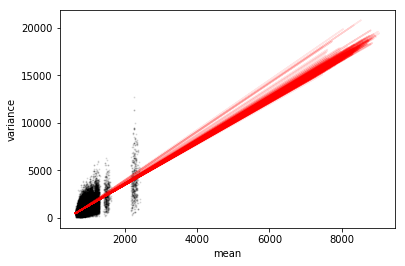

In [34]:
# use the de-jittered movie
movie_txy = dejittered_movie_txy

slope_list = []
intercept_list = []

if noise_estimation_config['plot_example']:
    fig = plt.figure()
    ax = plt.gca()
    ax.set_xlabel('mean')
    ax.set_ylabel('variance')
    
for i_bootstrap in range(noise_estimation_config['n_bootstrap']):
    
    # choose a random segment
    i_segment = np.random.randint(low=trim_config['first_segment'], high=trim_config['n_segments'])
    t, trimmed_seg_txy = get_flanking_segments(movie_txy, i_segment, trim_config)

    # choose a random time
    i_t = np.random.randint(0, high=len(t) - noise_estimation_config['stationarity_window'])

    # calculate empirical mean and variance, assuming signal stationarity
    mu_empirical = np.mean(trimmed_seg_txy[
        i_t:(i_t + noise_estimation_config['stationarity_window']), ...], axis=0).flatten()
    var_empirical = np.var(trimmed_seg_txy[
        i_t:(i_t + noise_estimation_config['stationarity_window']), ...], axis=0, ddof=1).flatten()
    
    # perform linear regression
    reg = LinearRegression().fit(mu_empirical[:, None], var_empirical[:, None])
    slope_list.append(reg.coef_.item())
    intercept_list.append(reg.intercept_.item())
    
    if noise_estimation_config['plot_example']:
        fit_var = reg.predict(mu_empirical[:, None])
        ax.scatter(
            mu_empirical[::noise_estimation_config['plot_subsample']],
            var_empirical[::noise_estimation_config['plot_subsample']],
            s=1,
            alpha=0.1,
            color='black')
        ax.plot(mu_empirical, fit_var, color='red', alpha=0.1)

In [35]:
alpha_median, alpha_std = np.median(slope_list), np.std(slope_list)
beta_median, beta_std = np.median(intercept_list), np.std(intercept_list)
print(f'alpha: {alpha_median:.3f} +- {alpha_std:.3f}')
print(f'beta: {beta_median:.3f} +- {beta_std:.3f}')

alpha: 2.225 +- 0.056
beta: -924.013 +- 44.591


In [36]:
# assert that the variance is never negative
global_min_variance = np.inf
for i_segment in range(trim_config['first_segment'], trim_config['n_segments']):
    _, seg_txy = get_trimmed_segment(movie_txy, i_segment, trim_config)
    min_obs_value_in_segment = np.min(seg_txy)
    min_variance = alpha_median * min_obs_value_in_segment + beta_median
    global_min_variance = min(global_min_variance, min_variance)
    print(f'min variance in segment {i_segment}: {min_variance:.3f}')
    assert min_variance > 0

min variance in segment 1: 301.971
min variance in segment 2: 312.465
min variance in segment 3: 275.199
min variance in segment 4: 308.554
min variance in segment 5: 268.548
min variance in segment 6: 288.132
min variance in segment 7: 304.222
min variance in segment 8: 304.136
min variance in segment 9: 266.381


In [37]:
noise_model_params = {
    'alpha_median': alpha_median,
    'alpha_std': alpha_std,
    'beta_median': beta_median,
    'beta_std': beta_std,
    'global_min_variance': global_min_variance
}

## Detrend

In [38]:
# trimmed segments of the movie
trimmed_segments_txy_list = []

# background activity fits
mu_segments_txy_list = []

movie_txy = dejittered_movie_txy

detrending segment 2 / 10 ...
i_iter: 0, loss: 3.958408
i_iter: 1, loss: 3.958390
i_iter: 2, loss: 3.958388
done!
detrending segment 3 / 10 ...
i_iter: 0, loss: 3.955404
i_iter: 1, loss: 3.955387
i_iter: 2, loss: 3.955383
done!
detrending segment 4 / 10 ...
i_iter: 0, loss: 3.956671
i_iter: 1, loss: 3.956654
i_iter: 2, loss: 3.956651
done!
detrending segment 5 / 10 ...
i_iter: 0, loss: 3.956432
i_iter: 1, loss: 3.956415
i_iter: 2, loss: 3.956412
done!
detrending segment 6 / 10 ...
i_iter: 0, loss: 3.955962
i_iter: 1, loss: 3.955944
i_iter: 2, loss: 3.955941
done!
detrending segment 7 / 10 ...
i_iter: 0, loss: 3.955460
i_iter: 1, loss: 3.955443
i_iter: 2, loss: 3.955439
done!
detrending segment 8 / 10 ...
i_iter: 0, loss: 3.955673
i_iter: 1, loss: 3.955656
i_iter: 2, loss: 3.955652
done!
detrending segment 9 / 10 ...
i_iter: 0, loss: 3.956169
i_iter: 1, loss: 3.956152
i_iter: 2, loss: 3.956148
done!
detrending segment 10 / 10 ...
i_iter: 0, loss: 3.956870
i_iter: 1, loss: 3.956853
i_ite

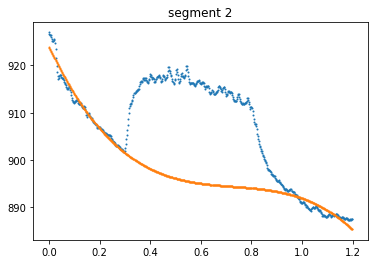

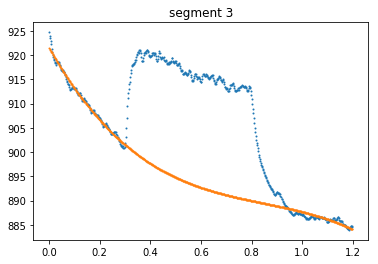

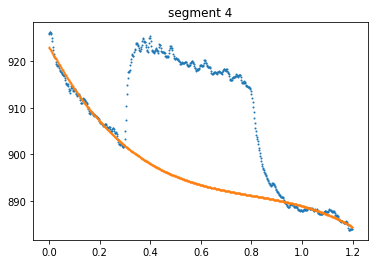

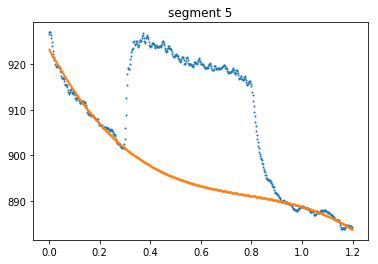

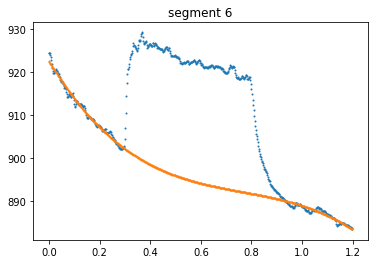

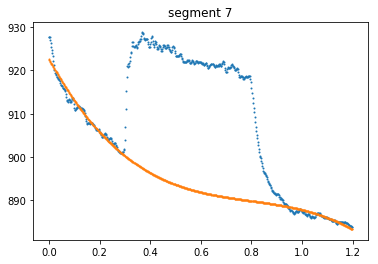

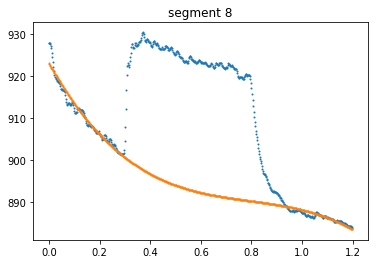

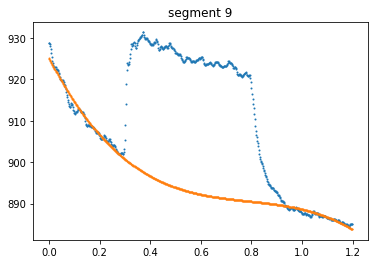

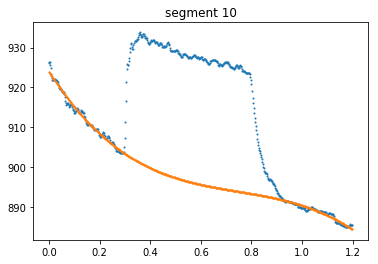

In [39]:
for i_segment in range(trim_config['first_segment'], trim_config['n_segments']):
    
    print(f"detrending segment {i_segment + 1} / {trim_config['n_segments']} ...")

    # get segment for fitting
    t_fit, fit_seg_txy = get_flanking_segments(movie_txy, i_segment, trim_config)
    t_fit_torch = torch.tensor(t_fit, device=device, dtype=dtype)
    fit_seg_txy_torch = torch.tensor(fit_seg_txy, device=device, dtype=dtype)
    
    if detrend_config['trend_model'] == 'polynomial':
        trend_model = PolynomialIntensityTrendModel(
            t_fit_torch=t_fit_torch,
            fit_seg_txy_torch=fit_seg_txy_torch,
            poly_order=detrend_config['poly_order'],
            device=device,
            dtype=dtype)
    elif detrend_config['trend_model'] == 'exponential':
        trend_model = ExponentialDecayIntensityTrendModel(
            t_fit=t_fit,
            fit_seg_txy=fit_seg_txy,
            init_unc_decay_rate=detrend_config['init_unc_decay_rate'],
            device=device,
            dtype=dtype)
    else:
        raise ValueError()

    # fit 
    optim = torch.optim.LBFGS(trend_model.parameters(), **bfgs_kwargs)

    def closure():
        optim.zero_grad()
        width, height = fit_seg_txy_torch.shape[1:]
        mu_txy = trend_model.get_baseline_txy(t_fit_torch)
        var_txy = torch.clamp(
            noise_model_params['alpha_median'] * mu_txy + noise_model_params['beta_median'],
            min=noise_model_params['global_min_variance'])
        loss_txy = 0.5 * (fit_seg_txy_torch - mu_txy).pow(2) / var_txy + 0.5 * var_txy.log()
        loss = loss_txy.sum()
        loss.backward()
        return loss
        
    for i_iter in range(detrend_config['max_iters_per_segment']):
        loss = optim.step(closure).item()
        print(f'i_iter: {i_iter}, loss: {loss / (width * height * len(t_fit)):.6f}')
    print('done!')

    t_trimmed, trimmed_seg_txy = get_trimmed_segment(movie_txy, i_segment, trim_config)
    t_trimmed_torch = torch.tensor(t_trimmed, device=device, dtype=dtype)
    mu_txy = trend_model.get_baseline_txy(t_trimmed_torch).detach().cpu().numpy()
    
    if detrend_config['plot_segments']:
        fig = plt.figure()
        ax = plt.gca()
        ax.scatter(t_trimmed, np.mean(trimmed_seg_txy, axis=(-1, -2)), s=1)
        ax.scatter(t_trimmed, np.mean(mu_txy, axis=(-1, -2)), s=1)
        ax.set_title(f'segment {i_segment + 1}')
        
    # store
    trimmed_segments_txy_list.append(trimmed_seg_txy)
    mu_segments_txy_list.append(mu_txy)

## Save

In [40]:
import json

In [41]:
trend_sub_movie_txy = np.concatenate([
    seg_txy - mu_txy
    for seg_txy, mu_txy in zip(trimmed_segments_txy_list, mu_segments_txy_list)],
    axis=0).astype(np.float32)
trend_movie_txy = np.concatenate(mu_segments_txy_list, axis=0).astype(np.float32)

In [42]:
output_file = os.path.join(output_path, opto_mov_prefixes[i_dataset] + "_trend_subtracted.npy")
np.save(output_file, trend_sub_movie_txy)

output_file = os.path.join(output_path, opto_mov_prefixes[i_dataset] + "_trend.npy")
np.save(output_file, trend_movie_txy)

In [43]:
output_file = os.path.join(output_path, opto_mov_prefixes[i_dataset] + "_noise_params.json")
with open(output_file, 'w') as f:
    json.dump(noise_model_params, f)